## Solve 2D diffusion-advection equation

This model allowed the validation of my code for a 2D heat transfer problem and is, therefore, not discussed in my master's thesis report. It is provided here only for reference. Details about the geometry and purpose of this simple model are provided in the file *Meshes/2D/2D_mesh.ipynb*.

In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.8.0
ipykernel        : 6.20.2
ipywidgets       : 7.7.2
jupyter_client   : 7.4.9
jupyter_core     : 5.1.4
jupyter_server   : 2.1.0
jupyterlab       : 3.5.3
nbclient         : 0.7.2
nbconvert        : 7.2.8
nbformat         : 5.7.3
notebook         : 6.5.2
qtconsole        : 5.4.0
traitlets        : 5.8.1


In [2]:
import numpy as np
import io
from mpi4py import MPI
import pyvista
import ufl
from ufl import Measure, FacetNormal
import matplotlib.pyplot as plt

import dolfinx
from dolfinx import fem, plot
from dolfinx.io import XDMFFile
from dolfinx.fem import FunctionSpace, VectorFunctionSpace, Constant, Function
from dolfinx.plot import create_vtk_mesh
from dolfinx.io.gmshio import read_from_msh 

from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

## Mesh reading

In [3]:
mesh, cell_tags, facet_tags = read_from_msh("../../meshes/2D/2D_mesh.msh", MPI.COMM_WORLD, 0)

Info    : Reading '../../Meshes/2D/2D_mesh.msh'...
Info    : 17 entities
Info    : 48023 nodes
Info    : 95424 elements
Info    : Done reading '../../Meshes/2D/2D_mesh.msh'


In [4]:
print(np.unique(cell_tags.values))
print(np.unique(facet_tags.values))

[101 102]
[1 2]


Uncomment the following cell to visualize the mesh and the different subdomains.

## Output file

In [6]:
xdmf = XDMFFile(mesh.comm, "solution_2D_model.xdmf", "w")
xdmf.write_mesh(mesh)

## Temporal parameters

In [7]:
t = 0              # start time
T = 1000000.*100   # final time
num_steps = 200    # number of steps
dt = T / num_steps # time step size

Text = 20 # initial temperature of the system
Tinj = 70 # temperature of injected water

## Finite element function space for temperature field

In [8]:
V = FunctionSpace(mesh, ("CG", 2))  # Lagrange quadratic elements (degree 2)

## Initial conditions

In [9]:
T_n = Function(V)
T_n.name = "T_n"
T_n.x.array[:] = np.full(len(T_n.x.array), Text)

Store the initial condition in another variable as T_n undergoes changes at each iteration, ensuring that the initial temperature is preserved for calculating different energies at each step.

In [10]:
T_i = T_n.copy()
T_i.name = "T_i"

## Time-dependent output

In [11]:
T_h = T_n.copy()
T_h.name = "T_h"
xdmf.write_function(T_h, t)

## Trial and test functions

In [12]:
T, r = ufl.TrialFunction(V), ufl.TestFunction(V)

## Material properties

In [13]:
# for water
rho_w = 997                  # density of water in kg/m³
c_w = 4182                   # specific heat of water in J/(kg*K)
cond_w = 0.598               # thermal conductivity of water in W/(m·K)
print("Thermal diffusivity of water:" + str(cond_w/(rho_w*c_w)))

# for metal (assume steel)
rho_m = 8000                 # density of metal in kg/m³
c_m = 420                    # specific heat of metal in J/(kg*K)
cond_m = 45                  # thermal conductivity of metal in W/(m·K)
print("Thermal diffusivity of metal:" + str(cond_m/(rho_m*c_m)))


# give those different properties to the domain
M = FunctionSpace(mesh, ("DG", 0))
fluid_mask = (cell_tags.values == 101)
metal_mask = (cell_tags.values == 102)

rho = Function(M)
rho.x.array[fluid_mask] = np.full(fluid_mask.sum(), rho_w)
rho.x.array[metal_mask] = np.full(metal_mask.sum(), rho_m)

c = Function(M)
c.x.array[fluid_mask] = np.full(fluid_mask.sum(), c_w)
c.x.array[metal_mask] = np.full(metal_mask.sum(), c_m)

cond = Function(M)
cond.x.array[fluid_mask] = np.full(fluid_mask.sum(), cond_w)
cond.x.array[metal_mask] = np.full(metal_mask.sum(), cond_m)

Thermal diffusivity of water:1.4342405504413766e-07
Thermal diffusivity of metal:1.3392857142857142e-05


## Fluid flow

In [14]:
Qinj = 0.001*1/10000 # 0.001*1/10000 to test conduction dominated regime and 0.001 to test advection dominated regime

# Finite element function space for fluid velocity field
Q = VectorFunctionSpace(mesh, ("DG", 0))
q = Function(Q)
num_cells = mesh.topology.index_map(mesh.topology.dim).size_local
block_size = Q.dofmap.index_map_bs  # number of dof per dofmap
for i in range(num_cells):
    if cell_tags.values[i] == 101:
        q.x.array[[i*block_size, i*block_size+1]] = [0., -Qinj]
    else:
        q.x.array[[i*block_size, i*block_size+1]] = [0., 0.]

Uncomment the following cell to visualize the fluid velocity field inside the domain.

## Boundary conditions

In [16]:
# DIRICHLET: T=Ti on side 1
boundary_dofs_inj = fem.locate_dofs_topological(V, mesh.topology.dim-1, facet_tags.indices[facet_tags.values == 1])
bc_inj = fem.dirichletbc(ScalarType(Tinj), boundary_dofs_inj, V)

bc_tot = [bc_inj]

# NEUMANN: natural BC

## Variational problem

In [17]:
F = rho * c * T * r * ufl.dx + dt * cond * ufl.dot(ufl.grad(T), ufl.grad(r)) * ufl.dx + dt * rho_w * c_w * ufl.dot(q, ufl.grad(T)) * r * ufl.dx \
    - (rho * c * T_n * r * ufl.dx)

In [18]:
a = ufl.lhs(F)
L = ufl.rhs(F)

## Linear algebra structures for the time dependent problem

In [19]:
bilinear_form = fem.form(a)
linear_form = fem.form(L)

In [20]:
%%time
# bilinear_form (a) isn't time dependant so we can assemble it once
A = fem.petsc.assemble_matrix(bilinear_form, bcs=bc_tot)
A.assemble()
b = fem.petsc.create_vector(linear_form)

CPU times: user 154 ms, sys: 56.4 ms, total: 210 ms
Wall time: 153 ms


## Custom integration measures

In [21]:
# integrate over subdomains
dx = Measure("dx", domain=mesh, subdomain_data=cell_tags)
# integrate over boundaries
ds = Measure("ds", domain=mesh, subdomain_data=facet_tags)
n = FacetNormal(mesh)

## Linear solver

In [22]:
%%time
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

CPU times: user 88 µs, sys: 9 µs, total: 97 µs
Wall time: 108 µs


In [23]:
%%time
E_stored = [0]  # at the initial state no energy is stored
E_input_conduction = [0]
E_input_advection = [0]
E_output_advection = [0]
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)
    
    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [bc_tot])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bc_tot)

    # Solve linear problem
    solver.solve(b, T_h.vector)
    T_h.x.scatter_forward()

    # Update solution at previous time step (T_n)
    T_n.x.array[:] = T_h.x.array
    
    # Write solution to file
    xdmf.write_function(T_h, t)
    
    # Compute stored energy
    I1 = fem.form(rho * c * (T_h-T_i) * dx((101, 102)))
    E_stored.append(fem.assemble_scalar(I1))
    
    # Compute input energy by conduction   
    I2 = fem.form(dt * cond * ufl.dot(ufl.grad(T_h), n) * ds(1))
    #I2 = fem.form(dt * cond * ufl.dot(ufl.grad(T_h), ufl.grad(T_h))**(1/2) * ds(1))
    E_input_conduction.append(fem.assemble_scalar(I2))
    
    # Compute input energy by advection
    I3 = fem.form(dt * rho * c * ufl.dot(q, -n) * (T_h-T_i) * ds(1))
    E_input_advection.append(fem.assemble_scalar(I3))
    
    # Compute output energy by advection
    I4 = fem.form(dt * rho * c * ufl.dot(q, n) * (T_h-T_i) * ds(2))
    E_output_advection.append(fem.assemble_scalar(I4))
    
    if i % 10 == 0:
        print(i)
        
xdmf.close()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
CPU times: user 16.2 s, sys: 2.82 s, total: 19 s
Wall time: 19 s


## Post-processing of results (energy balance)

In [24]:
# Analytical way to compute input energy by advection
cumulative_volume = Qinj*dt*np.array(range(0, num_steps+1, 1))
E_input_advection_ana = cumulative_volume*rho_w*c_w*(Tinj-Text)

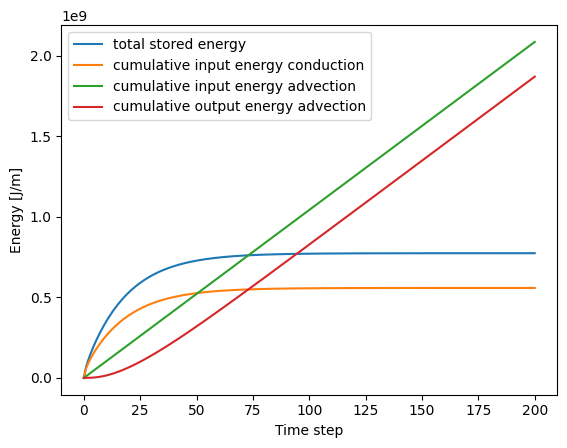

In [25]:
# Plot input and output energies to the system versus stored energy
plt.plot(np.array(E_stored), label = "total stored energy")
plt.plot(np.array(E_input_conduction).cumsum(), label = "cumulative input energy conduction")
plt.plot(np.array(E_input_advection).cumsum(), label = "cumulative input energy advection")
plt.plot(np.array(E_output_advection).cumsum(), label = "cumulative output energy advection")
plt.legend(loc="upper left")
plt.xlabel('Time step')
plt.ylabel('Energy [J/m]')
plt.show()

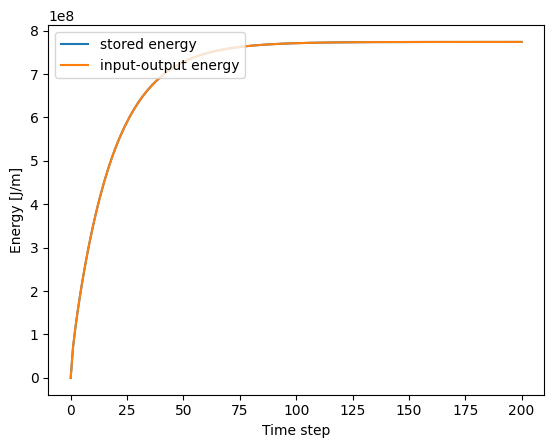

In [26]:
# Plot input-output energies to compare with stored energy
plt.plot(np.array(E_stored), label = "stored energy")
plt.plot(np.array(E_input_conduction).cumsum()+np.array(E_input_advection).cumsum()-np.array(E_output_advection).cumsum(), label = "input-output energy")
plt.legend(loc="upper left")
plt.xlabel('Time step')
plt.ylabel('Energy [J/m]')
plt.show()